In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [2]:
time1 = pd.read_csv('Time1-52_h2.csv' ,usecols = range(1,4) )

time2 = pd.read_csv('Time53-105_h2.csv' ,usecols = range(1,4))
time3 = pd.read_csv('Time105-156_h2.csv',usecols = range(1,4))
time4 = pd.read_csv('Time157-209_h2.csv',usecols = range(1,4))
time5 = pd.read_csv('Time209-260_h2.csv',usecols = range(1,4))


In [3]:
Time1 = np.array(time1)
Time2= np.array(time2)
Time3 = np.array(time3)
Time4 = np.array(time4)
Time5 = np.array(time5)





In [4]:
Time = np.concatenate((Time1,Time2,Time3,Time4,Time5) , axis =0)

In [4]:
def gettime(data):
    timedata= np.zeros(len(data))
    for i in range(len(data)):
            timedata[i] = +data[i,1]*86400*1000 +data[i,2]  -86400*1000
    
    return timedata

In [5]:
Time1 = gettime(Time1)

In [31]:
time = Time1[:20000001] 

In [6]:
mag1 = pd.read_csv('Mag_field_magni_1-52_h2.csv', usecols = range(1,2))
mag3 = pd.read_csv('Mag_field_magni_105-156_h2.csv', usecols = range(1,2))
mag4 = pd.read_csv('Mag_field_magni_157-208_h2.csv', usecols = range(1,2))
mag2 = pd.read_csv('Mag_field_magni_53-105_h2.csv', usecols = range(1,2))
mag5 = pd.read_csv('Mag_field_magni_209-260_h2.csv', usecols = range(1,2))

In [7]:
MAG1 = np.array(mag1)
MAG2 = np.array(mag2)
MAG3 = np.array(mag3)
MAG4 = np.array(mag4)
MAG5 = np.array(mag5)

In [8]:
mags = np.concatenate((MAG1,MAG2,MAG3,MAG4,MAG5) , axis =0)

In [32]:
mag = mags[:20000001]

In [10]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
   
    plt.figure(figsize=(80, 48))
    
    
    if type(y) is tuple:

      
      for y_curr in y:

       
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      
      plt.plot(x[start:end], y[start:end], format)

    
    plt.xlabel(xlabel)

    
    plt.ylabel(ylabel)

    
    if legend:
        plt.legend(legend)

    
    plt.title(title)

    plt.grid(True)

    plt.show()

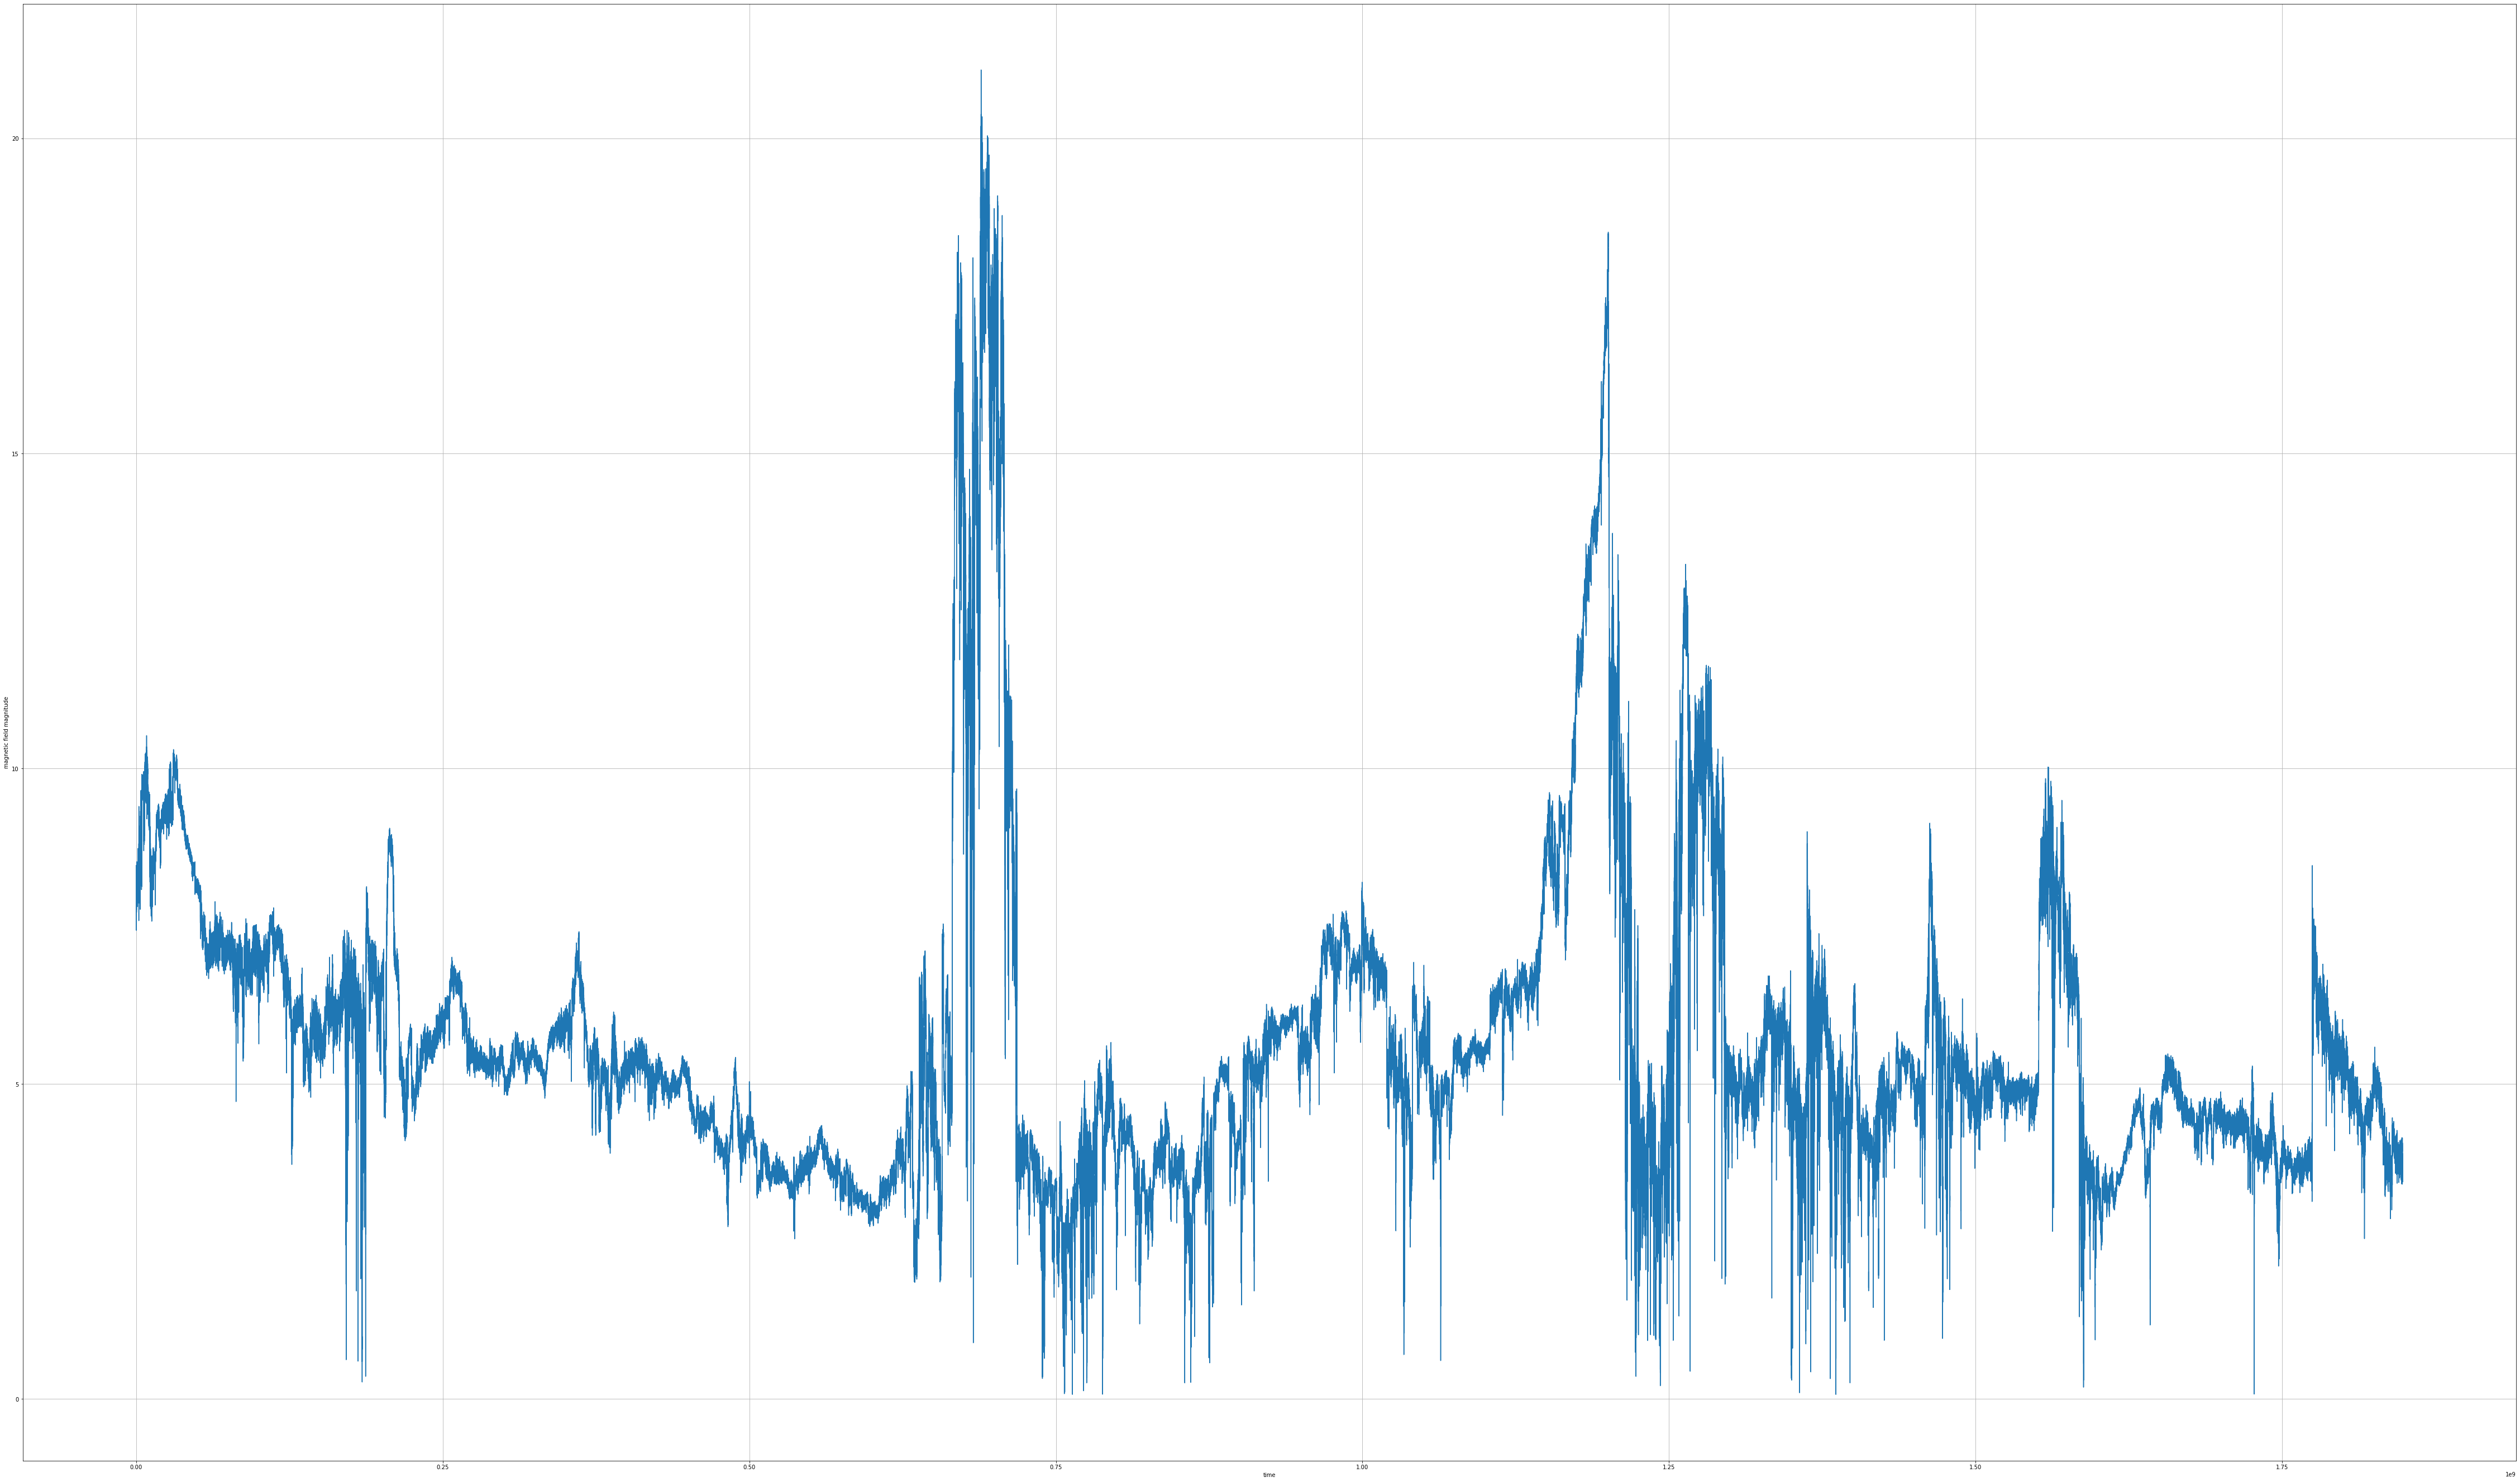

In [33]:
plot_series(time,mag,xlabel='time' , ylabel= 'magnetic field magnitude')

In [34]:
tf.keras.backend.clear_session()

In [35]:

split_time = 15000000

time_train = time[:split_time]
x_train = mags[:split_time]

time_valid = time[split_time:]
x_valid = mags[split_time:]

In [36]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [37]:
window_size = 100000
batch_size = 4
shuffle_buffer_size = 10

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [38]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=420, kernel_size=10000,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(420, return_sequences=True),
  tf.keras.layers.LSTM(420, return_sequences=True),
  tf.keras.layers.LSTM(420, return_sequences=True),
  tf.keras.layers.LSTM(420),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"),  
  tf.keras.layers.Dense(32, activation="relu"),   
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100000, 420)       4200420   
                                                                 
 lstm (LSTM)                 (None, 100000, 420)       1412880   
                                                                 
 lstm_1 (LSTM)               (None, 100000, 420)       1412880   
                                                                 
 lstm_2 (LSTM)               (None, 100000, 420)       1412880   
                                                                 
 lstm_3 (LSTM)               (None, 420)               1412880   
                                                                 
 dense (Dense)               (None, 256)               107776    
                                                                 
 dense_1 (Dense)             (None, 128)               3

In [39]:
init_weights = model.get_weights()

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


In [ ]:

lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8, 1e-3, 0, 100])

In [ ]:

tf.keras.backend.clear_session()

model.set_weights(init_weights)

In [ ]:

learning_rate = 8e-7

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:

history = model.fit(train_set,epochs=100)

In [ ]:

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) 

plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [ ]:
def model_forecast(model, series, window_size, batch_size):
   
    dataset = tf.data.Dataset.from_tensor_slices(series)

    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:

forecast_series = series[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [ ]:

print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

In [ ]:

def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(30, 18))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
        plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()
    
    
    # Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()


# Get initial weights
init_weights = model.get_weights()


# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])


# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)


# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


# Train the model
history = model.fit(train_set,epochs=100)


def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast


# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))


# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())